In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense,Input,Activation , concatenate , LSTM , Flatten ,Dropout
from keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
random.seed(45)
os.chdir("/content/drive/MyDrive/2024/NLP/LSTM/data")
train=pd.read_csv("preprocessed_data_feb2.csv")
train.head(1)

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students need opportunities to practice beg...,0,0,students english learners working english seco...,-0.390533,23


Splitting dataset

In [4]:
X=train.drop("project_is_approved" , axis=1)
Y=train["project_is_approved"]

le = preprocessing.LabelEncoder()
le.fit(Y)
y_enc = le.transform(Y)
Y = tf.keras.utils.to_categorical(y_enc, num_classes=2)

X_train , X_val  , Y_train , Y_val = train_test_split(X , Y , test_size=0.30 , stratify=Y)
X_val ,X_test,Y_val ,Y_test= train_test_split(X_val , Y_val , test_size=0.30 , stratify=Y_val)

print(X_train.shape , Y_train.shape)
print(X_val.shape , Y_val.shape)
print(X_test.shape , Y_test.shape )

(76473, 11) (76473, 2)
(22942, 11) (22942, 2)
(9833, 11) (9833, 2)


*EMBEDDING MATRIX ESSAY*

In [5]:
x=X_train["essay"].tolist()

print(len(x[0]))  , print(x[0])
print(len(x[1])) , print(x[1])

1169
students come school eager learn explore excited talk friends teacher young age children acquire new skills every day biggest challenge getting students attention keeping engaged activity play often talked relief serious learning children play serious learning play really work childhood fred rogers teach 24 wonderful four five year old children love learning enjoy coming school every day happy inquisitive curious energetic love learn play want students look forward coming school every day fun learn want first experience school positive students need dollhouse dollhouse furniture dolls increase imaginative play skills pretend play important young children sturdy dollhouse last years accessible four sides plexiglas roof gives children clear view inside house dolls soft yet durable easy put sitting position furniture allow children set rooms wish children enjoy pretend cooking dolls kitchen putting dolls sleep blanket bed playing dolls dollhouse encourage cooperative play children in

(None, None)

In [8]:
#tokenizing doc
t = Tokenizer()
t.fit_on_texts(x)
len(t.word_index.items())

vocab_size = len(t.word_index) + 1

print( "number of words in Dict " ,len(t.word_index.items()))

encoded_docs_train_essay = t.texts_to_sequences(X_train["essay"])
encoded_docs_val_essay = t.texts_to_sequences(X_val["essay"])
encoded_docs_test_essay = t.texts_to_sequences(X_test["essay"])

print("="*50)
print(list(X_train["essay"])[0])
print("="*50)
print(encoded_docs_train_essay[0])

number of words in Dict  48960
students come school eager learn explore excited talk friends teacher young age children acquire new skills every day biggest challenge getting students attention keeping engaged activity play often talked relief serious learning children play serious learning play really work childhood fred rogers teach 24 wonderful four five year old children love learning enjoy coming school every day happy inquisitive curious energetic love learn play want students look forward coming school every day fun learn want first experience school positive students need dollhouse dollhouse furniture dolls increase imaginative play skills pretend play important young children sturdy dollhouse last years accessible four sides plexiglas roof gives children clear view inside house dolls soft yet durable easy put sitting position furniture allow children set rooms wish children enjoy pretend cooking dolls kitchen putting dolls sleep blanket bed playing dolls dollhouse encourage co

In [9]:
#padding doc
len_list=[]
for i in range(0 , len(encoded_docs_train_essay)):
  len_list.append(len(encoded_docs_train_essay[i]))

max_length_essay =max(len_list)

print("max length of essay:" ,max_length_essay)

padded_docs_train_essay = pad_sequences(encoded_docs_train_essay, maxlen=max_length_essay, padding='post')
padded_docs_val_essay = pad_sequences(encoded_docs_val_essay, maxlen=max_length_essay, padding='post')
padded_docs_test_essay = pad_sequences(encoded_docs_test_essay, maxlen=max_length_essay, padding='post')

print("="*50)
print(padded_docs_train_essay[1])

max length of essay: 320
[ 1378    23     2    24    23   194    23  2785    23     1   669    88
   144   196    46  6112  2905     3    73    22  2570    88    10     8
   101   419  1361    34    76     1  1827 10235  1502  1193   224  2836
    41    35     1    44     3   993    30  1186     5   693   150   136
   924    29   263    50   263   116     1   229  7850  9478  2133  1824
   262  1824    85    26    83    96   391   602    31     1    24     8
   146    17   400  1003    40   118  1066     1     8  1789    20    30
  1813   252   419   454    33  1288    42     7     1     6  2853   468
   454   176    20    28   248  2668  3445    11   361   125   124   359
   242   838   388  2245   495     1     9     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

In [11]:
#glove vec
with open('glove_vectors', 'rb') as f:
  model = pickle.load(f)

#if we have glove vec for word then we will use vec else that index will remain zeros
embedding_matrix_essay = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
	      embedding_matrix_essay[i]=embedding_vector

embedding_matrix_essay.shape  , vocab_size ,max_length_essay

((48961, 300), 48961, 320)

CLEAN CATEGORY

In [14]:
#label encoding clean categories
e = preprocessing.LabelEncoder()
le.fit(X_train["clean_categories"])
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
clean_cat_classes = len(list(le.classes_))
print("number of clean_categories classes :" ,clean_cat_classes)

#transform train clean categories into encoding
clean_cat_encoded_xtrain=le.transform(X_train["clean_categories"])

#few clean categories not available in train so making it mark it as -1
#val
clean_cat_encoded_xval=[]
for i in X_val["clean_categories"]:
  if i in le_dict:
    clean_cat_encoded_xval.append(le_dict[i])
  else: clean_cat_encoded_xval.append(-1)

#test
clean_cat_encoded_xtest=[]
for i in X_test["clean_categories"]:
  if i in le_dict:
    clean_cat_encoded_xtest.append(le_dict[i])
  else: clean_cat_encoded_xtest.append(-1)

clean_cat_encoded_xval=np.array(clean_cat_encoded_xval)
clean_cat_encoded_xtest=np.array(clean_cat_encoded_xtest)

number of clean_categories classes : 51


In [16]:
le = preprocessing.LabelEncoder()
le.fit(X_train["clean_subcategories"])
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
clean_subcategories_classes = len(le.classes_)
print("number of classes in clean subcategories :" ,clean_subcategories_classes )
clean_subcat_encoded_xtrain=le.transform(X_train["clean_subcategories"])

#val
clean_subcat_encoded_xval=[]
for i in X_val["clean_subcategories"]:
  if i in le_dict:
    clean_subcat_encoded_xval.append(le_dict[i])
  #adding  length of classes as unknown category , if we dont have categories in train dataset
  else: clean_subcat_encoded_xval.append(len(le.classes_))

#test
clean_subcat_encoded_xtest=[]
for i in X_test["clean_subcategories"]:
  if i in le_dict:
    clean_subcat_encoded_xtest.append(le_dict[i])
  else: clean_subcat_encoded_xtest.append(len(le.classes_))

clean_subcat_encoded_xval =np.array(clean_subcat_encoded_xval)
clean_subcat_encoded_xtest=np.array(clean_subcat_encoded_xtest)

number of classes in clean subcategories : 389


In [17]:
class_clean_subcat=len(le_dict)

# **label encoding for rest of  features**

In [25]:
def label_encoding(x):
  le = preprocessing.LabelEncoder()
  le.fit(X_train[x])
  classes=len(list(le.classes_))
  print(f"number of classes {x} :", classes)
  transformed_x_train=le.transform(X_train[x])
  transformed_x_test=le.transform(X_test[x])
  transformed_x_val=le.transform(X_val[x])
  print("=="*50)
  print( "train shape :" ,transformed_x_train.shape ,"val shape :" , transformed_x_val.shape ,  "test shape :",transformed_x_test.shape)
  return transformed_x_train , transformed_x_val ,transformed_x_test , classes

school

In [26]:
school_state_xtrain , school_state_xval ,school_state_xtest , classes_school_state =label_encoding("school_state")

number of classes school_state : 51
train shape : (76473,) val shape : (22942,) test shape : (9833,)


teacher_prefix

In [27]:
teacher_prefix_xtrain ,teacher_prefix_x_val ,teacher_prefix_x_test , classes_teacher_prefix =label_encoding("teacher_prefix")

number of classes teacher_prefix : 5
train shape : (76473,) val shape : (22942,) test shape : (9833,)


project_grade_category

In [28]:
project_grade_category_xtrain ,project_grade_category_x_val ,project_grade_category_x_test , classes_project_grade_category =label_encoding("project_grade_category")

number of classes project_grade_category : 4
train shape : (76473,) val shape : (22942,) test shape : (9833,)


clean_subcategories

price

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train['price'].values.reshape(-1,1))
scaler.transform(X_train['price'].values.reshape(-1, 1) )
X_train_price = scaler.transform(X_train['price'].values.reshape(-1,1))
X_val_price = scaler.transform(X_val['price'].values.reshape(-1,1))
X_test_price = scaler.transform(X_test['price'].values.reshape(-1,1))

teacher_number_of_previously_posted_projects

In [30]:
scaler = StandardScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )
X_train_prev_proj = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_val_prev_proj = scaler.transform(X_val['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_proj = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [31]:
price_prev_proj_x_train=np.hstack((X_train_price ,X_train_prev_proj))
price_prev_proj_x_val=np.hstack((X_val_price ,X_val_prev_proj))
price_prev_proj_x_test=np.hstack((X_test_price ,X_test_prev_proj))

In [32]:
print(classes_school_state)
print(classes_teacher_prefix)
print(classes_project_grade_category)
print(clean_subcategories_classes)
print(clean_cat_classes)
print(max_length_essay)

51
5
4
389
51
320


Modle 1

In [39]:
tf.keras.backend.clear_session()

In [34]:
embedding_size_school_state=classes_school_state
embedding_size_project_grade_cat=classes_project_grade_category
embedding_size_clean_cat=clean_cat_classes
embedding_size_clean_subcat=clean_subcategories_classes
embedding_size_teacher_prefix=classes_teacher_prefix

In [40]:
epoch=10
batch_size=int(564)
steps_per_epoch=int(len(X_train)/batch_size)
dropout_rate = 0.5
output_activation = 'sigmoid'

In [41]:
input1 =Input(shape=(max_length_essay,), dtype='int32')
embedding_essay=Embedding(vocab_size , 300  , weights=[embedding_matrix_essay] , input_length=max_length_essay  , trainable=False)(input1)
lstm =LSTM(32, return_sequences=True)(embedding_essay)
flatten_essay=Flatten()(lstm)

input2 =Input(shape=(1,), dtype='int32')
embedding_cleancat=Embedding(51 ,  input_length=1  ,output_dim =embedding_size_clean_cat, trainable=False)(input2)
flatten_cleancat=Flatten()(embedding_cleancat)

input3 =Input(shape=(1,), dtype='int32')
embedding_clean_subcat=Embedding(394,  input_length=1  ,output_dim =embedding_size_clean_subcat , trainable=False)(input3)
flatten_clean_subcat=Flatten()(embedding_clean_subcat)

input4 =Input(shape=(1,), dtype='int32')
embedding_school_state=Embedding(classes_school_state ,  input_length=1  ,output_dim =embedding_size_school_state, trainable=False)(input4)
flatten_school_state=Flatten()(embedding_school_state)

input5 =Input(shape=(1,), dtype='int32')
embedding_teacher_prefix=Embedding(classes_teacher_prefix,  input_length=1  ,output_dim =embedding_size_teacher_prefix, trainable=False)(input5)
flatten_teacher_prefix=Flatten()(embedding_teacher_prefix)

input6 =Input(shape=(1,), dtype='int32')
embedding_project_grade_category=Embedding(classes_project_grade_category,  input_length=1  ,output_dim =embedding_size_project_grade_cat, trainable=False)(input6)
flatten_project_grade_category=Flatten()(embedding_project_grade_category)

input7 =Input(shape=(2,))
flatten_price_prev_proj=Flatten()(input7)

input_list=[flatten_essay,flatten_cleancat , flatten_clean_subcat , flatten_school_state  , flatten_teacher_prefix , flatten_project_grade_category ,flatten_price_prev_proj]
inputdata=[padded_docs_train_essay ,clean_cat_encoded_xtrain ,clean_subcat_encoded_xtrain , school_state_xtrain ,teacher_prefix_xtrain , project_grade_category_xtrain , price_prev_proj_x_train ]
X_val_list=[padded_docs_val_essay , clean_cat_encoded_xval, clean_subcat_encoded_xval   , school_state_xval ,teacher_prefix_x_val , project_grade_category_x_val , price_prev_proj_x_val]
X_test_list=[padded_docs_test_essay , clean_cat_encoded_xtest, clean_subcat_encoded_xtest   , school_state_xtest ,teacher_prefix_x_test , project_grade_category_x_test , price_prev_proj_x_test]
input=[input1 , input2 , input3 , input4 , input5 , input6 ,input7]

In [42]:
concat=concatenate(inputs=input_list, name="concat")
layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(concat)
drop_out1=Dropout(dropout_rate)(layer1)

layer2 = Dense(25,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(drop_out1)
drop_out2=Dropout(dropout_rate)(layer2)

layer4 = Dense(10 ,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(drop_out2)

output = Dense(2, activation=output_activation)(layer4)
model = Model(inputs=input, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.00001)
#chatGPT changes
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

tb = TensorBoard('/content/tensorboard_log/model1')
model.fit(inputdata, Y_train, epochs=epoch ,validation_data=(X_val_list, Y_val)  , steps_per_epoch=steps_per_epoch ,   batch_size=batch_size ,  verbose=2 , callbacks=tb )

Epoch 1/10
135/135 - 10s - loss: 0.5874 - auc: 0.8022 - val_loss: 0.4936 - val_auc: 0.8579 - 10s/epoch - 71ms/step
Epoch 2/10
135/135 - 4s - loss: 0.5235 - auc: 0.8343 - val_loss: 0.4733 - val_auc: 0.8610 - 4s/epoch - 31ms/step
Epoch 3/10
135/135 - 4s - loss: 0.5121 - auc: 0.8408 - val_loss: 0.4746 - val_auc: 0.8626 - 4s/epoch - 32ms/step
Epoch 4/10
135/135 - 4s - loss: 0.5048 - auc: 0.8436 - val_loss: 0.4835 - val_auc: 0.8639 - 4s/epoch - 33ms/step
Epoch 5/10
135/135 - 4s - loss: 0.4953 - auc: 0.8471 - val_loss: 0.4828 - val_auc: 0.8649 - 4s/epoch - 32ms/step
Epoch 6/10
135/135 - 4s - loss: 0.4934 - auc: 0.8471 - val_loss: 0.4790 - val_auc: 0.8665 - 4s/epoch - 32ms/step
Epoch 7/10
135/135 - 4s - loss: 0.4879 - auc: 0.8492 - val_loss: 0.4711 - val_auc: 0.8681 - 4s/epoch - 33ms/step
Epoch 8/10
135/135 - 4s - loss: 0.4821 - auc: 0.8508 - val_loss: 0.4636 - val_auc: 0.8699 - 4s/epoch - 32ms/step
Epoch 9/10
135/135 - 4s - loss: 0.4800 - auc: 0.8513 - val_loss: 0.4642 - val_auc: 0.8720 - 4s

In [38]:
%load_ext tensorboard
!kill 3332
!rm -rf ./logs/
import datetime
%tensorboard --logdir=/content/tensorboard_log

/bin/bash: line 1: kill: (3332) - No such process


<IPython.core.display.Javascript object>

In [ ]:
dot_img_file = '/content/model_2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## **MODEL 2**

TF-IDF

In [43]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tf.keras.backend.clear_session()

In [44]:
#tfidf for essay
vectorizer=TfidfVectorizer(min_df=10  )
vectorizer_fit=vectorizer.fit(X_train['essay'].values)
idf_values=vectorizer_fit.idf_

In [45]:
print(idf_values[1000:1020])
print("=="*50)
print(vectorizer.get_feature_names_out()[1000:1020])

[7.52620722 8.60711993 8.60711993 5.67102593 5.29676902 9.02583027
 9.41149275 6.81975608 6.7272532  7.581267   7.99621085 8.84350871
 7.38489369 9.06665226 7.99621085 9.53665589 6.23099094 9.67975674
 7.63953591 9.41149275]
['asks' 'asl' 'asleep' 'aspect' 'aspects' 'asperger' 'aspiration'
 'aspirations' 'aspire' 'aspiring' 'assemble' 'assembled' 'assemblies'
 'assembling' 'assembly' 'asses' 'assess' 'assessable' 'assessed'
 'assesses']


In [47]:
#checking percentile values for idf
for i in range(0,100,5):
    idf =idf_values
    idf = np.sort(idf,axis = None)
    print("{} percentile value is {}".format(i,idf[int(len(idf)*(float(i)/100))]))

0 percentile value is 1.0075077792672407
5 percentile value is 4.5860065344966285
10 percentile value is 5.4534846300387425
15 percentile value is 6.056441969682338
20 percentile value is 6.550973953962228
25 percentile value is 6.951401268040436
30 percentile value is 7.303063670155623
35 percentile value is 7.590745742607404
40 percentile value is 7.837986845500675
45 percentile value is 8.07031882286929
50 percentile value is 8.274414179212805
55 percentile value is 8.50703647448156
60 percentile value is 8.689358031275514
65 percentile value is 8.877410262778454
70 percentile value is 9.066652262416982
75 percentile value is 9.248973819210937
80 percentile value is 9.411492748708712
85 percentile value is 9.536655891662718
90 percentile value is 9.67975673530339
95 percentile value is 9.759799442976927


In [48]:
#using idf values between 25th to 75th so we will remove 75th percentile+ words which are very common and below 25th which is less in number
feature_idf_values = zip(vectorizer.get_feature_names_out(),idf_values)

percentile_25 = np.percentile(idf_values,[25])
percentile_75 = np.percentile(idf_values,[75])

feature_name_idf = []
for word , idf_values in feature_idf_values:
    if idf_values >= percentile_25 and idf_values <= percentile_75:
        feature_name_idf.append(word)

print(len(feature_name_idf))

7416


In [49]:
print(feature_name_idf[2000:2050])

['disk', 'disks', 'dislike', 'dislikes', 'dismissal', 'disney', 'disorganized', 'disparity', 'dispenser', 'displaced', 'displaying', 'displays', 'disposable', 'disposal', 'disrepair', 'disrupt', 'disrupted', 'disruption', 'disruptions', 'disrupts', 'dissect', 'dissecting', 'dissection', 'dissections', 'disservice', 'distances', 'distant', 'distinct', 'distinction', 'distinctive', 'distinguish', 'distinguished', 'distracts', 'distress', 'distribute', 'distributed', 'distribution', 'disturb', 'disturbances', 'disturbed', 'ditch', 'divergent', 'diversified', 'diversify', 'diversities', 'divide', 'divided', 'divider', 'dividers', 'dividing']


In [50]:
#remove words which do not came under 25th-75th from essay
def text_to_idf(text):
  preprocessed_text = []
  for sent in tqdm(text):
    split_words = sent.split()
    preprocessed_sent = ''
    for word in split_words:
      if(word in feature_name_idf):
        preprocessed_sent += ' ' + word
    preprocessed_text.append(preprocessed_sent)
  return preprocessed_text

In [51]:
#saving preprocessed essay

# X_train_preprocessed_essay= text_to_idf(X_train['essay'])
# X_val_preprocessed_essay= text_to_idf(X_val['essay'])
# X_test_preprocessed_essay= text_to_idf(X_test['essay'])

# file_name="X_train_preprocessed_essay"
# open_file = open(file_name, "wb")
# pickle.dump(X_train_preprocessed_essay, open_file)

# file_name="X_val_preprocessed_essay"
# open_file = open(file_name, "wb")
# pickle.dump(X_val_preprocessed_essay, open_file)

# file_name="X_test_preprocessed_essay"
# open_file = open(file_name, "wb")
# pickle.dump(X_test_preprocessed_essay, open_file)

In [52]:
open_file = open("X_train_preprocessed_essay", "rb")
X_train_preprocessed_essay = pickle.load(open_file)

open_file = open("X_val_preprocessed_essay", "rb")
X_val_preprocessed_essay = pickle.load(open_file)

open_file = open("X_test_preprocessed_essay", "rb")
X_test_preprocessed_essay = pickle.load(open_file)

In [53]:
t = Tokenizer()
t.fit_on_texts(X_train_preprocessed_essay)

In [54]:
encoded_docs_train = t.texts_to_sequences(X_train_preprocessed_essay)
encoded_docs_val = t.texts_to_sequences(X_val_preprocessed_essay)
encoded_docs_test = t.texts_to_sequences(X_test_preprocessed_essay)

print(X_train_preprocessed_essay[2])
print(encoded_docs_train[2])

noodle nineteen noodle noodle divided blocked
[937, 3389, 937, 937, 517, 7024]


In [55]:
len_list_essay=[]
for i in range(0 , len(encoded_docs_train)):
  len_list_essay.append(len(encoded_docs_train[i]))
max(len_list_essay)

max_length =max(len_list_essay)
padded_docs_train_essay = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_val_essay = pad_sequences(encoded_docs_val, maxlen=max_length, padding='post')
padded_docs_test_essay = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [56]:
with open('glove_vectors', 'rb') as f:
  model = pickle.load(f)
vocab_size = len(t.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
	      embedding_matrix[i]=embedding_vector

In [57]:
print(len(embedding_matrix[0]) , len(embedding_matrix)) ,

300 7405


(None,)

In [58]:
input1 =Input(shape=(max_length,), dtype='int32')
embedding_essay=Embedding(vocab_size , 300  , weights=[embedding_matrix] , input_length=max_length  , trainable=False)(input1)
lstm =LSTM(32, return_sequences=True)(embedding_essay)
flatten_essay=Flatten()(lstm)

input2 =Input(shape=(1,), dtype='int32')
embedding_cleancat=Embedding(51 ,  input_length=1  ,output_dim =embedding_size_clean_cat, trainable=False)(input2)
flatten_cleancat=Flatten()(embedding_cleancat)

input3 =Input(shape=(1,), dtype='int32')
embedding_clean_subcat=Embedding(394,  input_length=1  ,output_dim =embedding_size_clean_subcat , trainable=False)(input3)
flatten_clean_subcat=Flatten()(embedding_clean_subcat)

input4 =Input(shape=(1,), dtype='int32')
embedding_school_state=Embedding(classes_school_state ,  input_length=1  ,output_dim =embedding_size_school_state, trainable=False)(input4)
flatten_school_state=Flatten()(embedding_school_state)

input5 =Input(shape=(1,), dtype='int32')
embedding_teacher_prefix=Embedding(classes_teacher_prefix,  input_length=1  ,output_dim =embedding_size_teacher_prefix, trainable=False)(input5)
flatten_teacher_prefix=Flatten()(embedding_teacher_prefix)

input6 =Input(shape=(1,), dtype='int32')
embedding_project_grade_category=Embedding(classes_project_grade_category,  input_length=1  ,output_dim =embedding_size_project_grade_cat, trainable=False)(input6)
flatten_project_grade_category=Flatten()(embedding_project_grade_category)


input7 =Input(shape=(2,))
flatten_price_prev_proj=Flatten()(input7)

In [59]:
input_list=[flatten_essay,flatten_cleancat , flatten_school_state  , flatten_teacher_prefix , flatten_project_grade_category , flatten_clean_subcat ,flatten_price_prev_proj]
inputdata=[padded_docs_train_essay ,clean_cat_encoded_xtrain ,clean_subcat_encoded_xtrain , school_state_xtrain ,teacher_prefix_xtrain , project_grade_category_xtrain , price_prev_proj_x_train ]
X_val_list=[padded_docs_val_essay , clean_cat_encoded_xval, clean_subcat_encoded_xval   , school_state_xval ,teacher_prefix_x_val , project_grade_category_x_val , price_prev_proj_x_val]
X_test_list=[padded_docs_test_essay , clean_cat_encoded_xtest, clean_subcat_encoded_xtest   , school_state_xtest ,teacher_prefix_x_test , project_grade_category_x_test , price_prev_proj_x_test]
input=[input1 , input2 , input3 , input4 , input5 , input6 ,input7]

In [63]:
epoch=10
batch_size=564
steps_per_epoch=int(len(X_train)/batch_size)

In [64]:
!rm -rf /content/tensorboard_log

In [66]:
concat=concatenate(inputs=input_list, name="concat")
layer1 = Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(concat)
drop_out1=Dropout(dropout_rate)(layer1)

layer2 = Dense(25,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(drop_out1)
drop_out2=Dropout(dropout_rate)(layer2)

# layer3 = Dense(25,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(drop_out2)
# drop_out3=Dropout(dropout_rate)(layer3)

layer4 = Dense(10 ,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(drop_out2)

output = Dense(2, activation=output_activation)(layer4)
model = Model(inputs=input, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.0001)
#chatGPT changes
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

tb = TensorBoard('/content/tensorboard_log/model1')
model.fit(inputdata, Y_train, epochs=epoch ,validation_data=(X_val_list, Y_val)  , steps_per_epoch=steps_per_epoch ,   batch_size=batch_size ,  verbose=2 , callbacks=tb )

Epoch 1/10
135/135 - 5s - loss: 0.5708 - auc_2: 0.8016 - val_loss: 0.4432 - val_auc_2: 0.8532 - 5s/epoch - 39ms/step
Epoch 2/10
135/135 - 1s - loss: 0.5076 - auc_2: 0.8418 - val_loss: 0.4345 - val_auc_2: 0.8571 - 1s/epoch - 10ms/step
Epoch 3/10
135/135 - 1s - loss: 0.4853 - auc_2: 0.8495 - val_loss: 0.4355 - val_auc_2: 0.8614 - 1s/epoch - 10ms/step
Epoch 4/10
135/135 - 1s - loss: 0.4750 - auc_2: 0.8509 - val_loss: 0.4337 - val_auc_2: 0.8659 - 1s/epoch - 10ms/step
Epoch 5/10
135/135 - 1s - loss: 0.4665 - auc_2: 0.8526 - val_loss: 0.4310 - val_auc_2: 0.8682 - 1s/epoch - 9ms/step
Epoch 6/10
135/135 - 1s - loss: 0.4602 - auc_2: 0.8538 - val_loss: 0.4263 - val_auc_2: 0.8688 - 1s/epoch - 10ms/step
Epoch 7/10
135/135 - 1s - loss: 0.4574 - auc_2: 0.8531 - val_loss: 0.4297 - val_auc_2: 0.8708 - 1s/epoch - 10ms/step
Epoch 8/10
135/135 - 1s - loss: 0.4514 - auc_2: 0.8556 - val_loss: 0.4301 - val_auc_2: 0.8717 - 1s/epoch - 9ms/step
Epoch 9/10
135/135 - 1s - loss: 0.4477 - auc_2: 0.8570 - val_loss:

In [ ]:
%load_ext tensorboard
!kill 956
!rm -rf ./logs/
import datetime
%tensorboard --logdir=/content/tensorboard_log

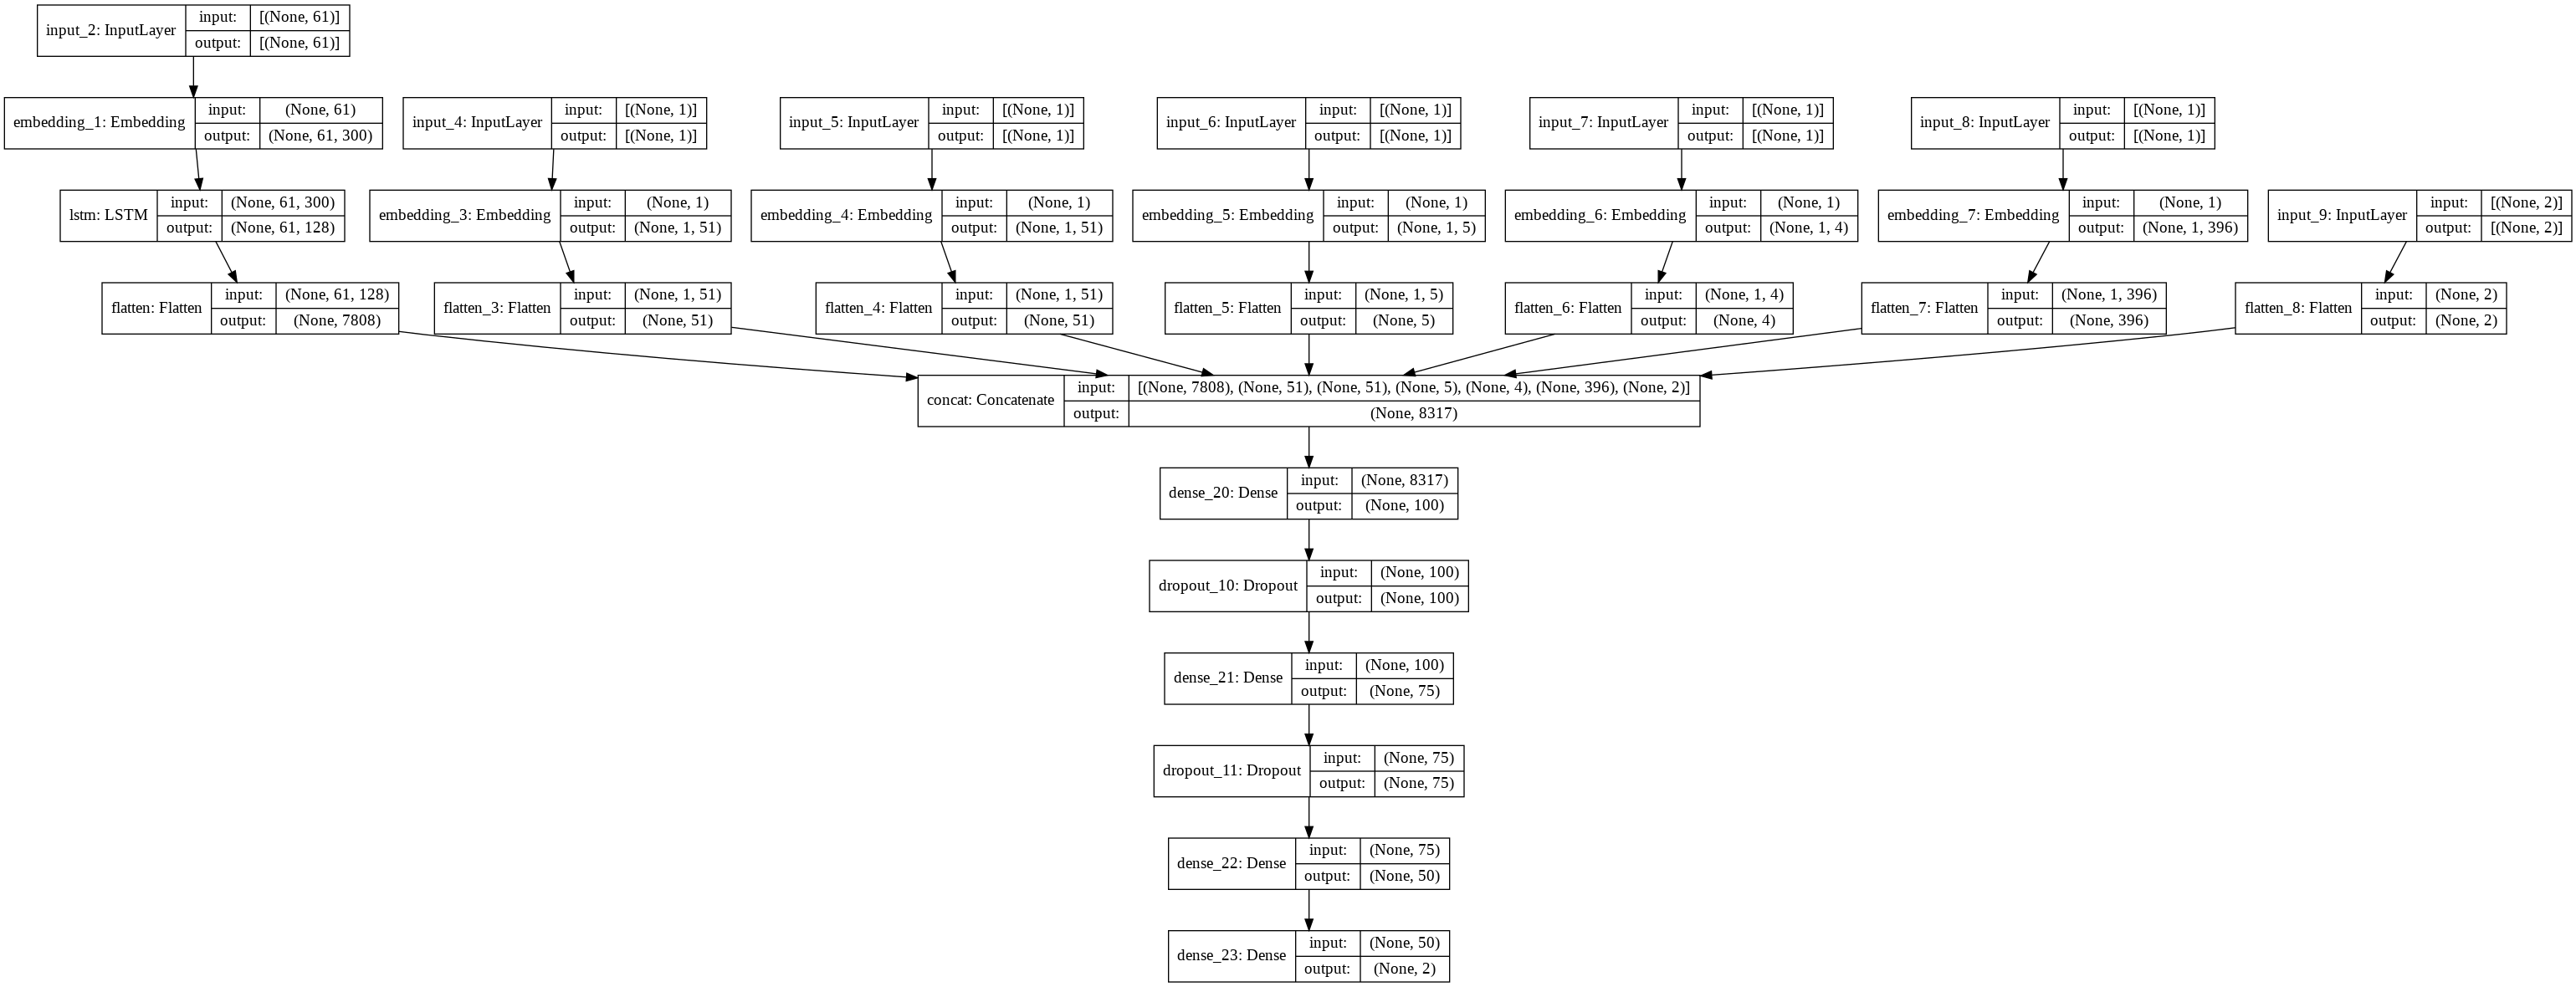

In [ ]:
dot_img_file = '/content/model_2.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

we can also exp with one hot encoding tech for school state , clean cat , teacher prefix